# Transfer Learning

## Import the Necessary Libraries

In [61]:
# Importing the necessary libraries
import time
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Check for Available GPU

In [62]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Set Dataset Locations

The dataset used in this part is also from Kaggle. It is the 'Flower Image Dataset':

https://www.kaggle.com/datasets/phucthaiv02/flower-image-dataset

This notebook should run on Kaggle and the dataset should already be loaded from the relavant option in the side menu. In order for the notrebook to run locally, the pathing for train_dir and val_dir should be adjusted accordingly.

Note: There is no data augmentation on this dataset and I chose not to apply either as the dataset is already too big and some experiments I made earlier with data augmentation increased the training times significantly.

In [63]:
# location of the training and validation data for the Flower Image dataset
train_dir = "/kaggle/input/flower-image-dataset/flower-image/train"
val_dir = "/kaggle/input/flower-image-dataset/flower-image/val"

## Resize Images | Set Batch Size | Create Train and Validation Datasets

The following code resizes the images to 180x180 and sets the batch size to 64.

In [97]:
image_size = (180, 180)
batch_size = 64

train_ds_flowim = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_flowim = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 45492 files belonging to 104 classes.
Found 12157 files belonging to 104 classes.


## Exploration of the Classes

In [65]:
class_names = train_ds_flowim.class_names
num_classes = len(class_names)

print('This dataset contains', num_classes, 'flower classes.')

This dataset contains 104 flower classes.


## Some Sample Images from the Dataset

A sample of 9 images in the dataset. As we can see, data augmentation has already been applied in this dataset.

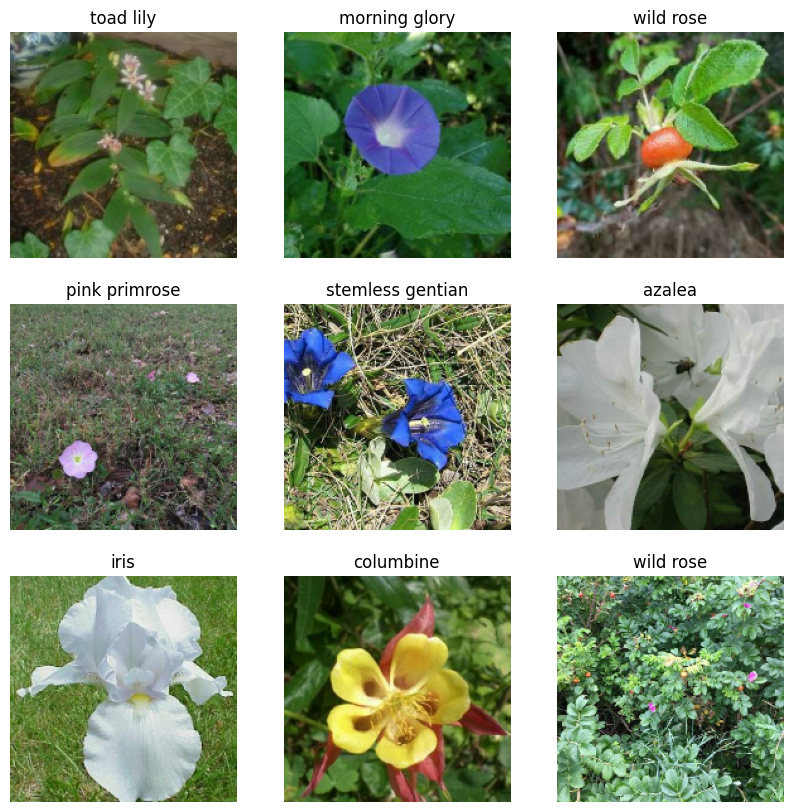

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_flowim.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        flower_name = class_names[label]
        plt.imshow(image)
        plt.title(flower_name)
        plt.axis("off")

## Helper Functions

The helper function used are the same as the ones in the training of the CNN in part 1. A brief explanation about what each function does can be found in the comments.

In [67]:
# A function that displays the model layers and the parameters of each layer as well as the frozen (non-trainable) parameters
def display_model_stats(model):
    print(model.summary())

In [68]:
# A function to plot the training and validation accuracy and loss
def plot_model_accuracy_and_loss(metrics):
    acc = metrics.history["accuracy"]
    val_acc = metrics.history["val_accuracy"]
    loss = metrics.history["loss"]
    val_loss = metrics.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    ax1.plot(epochs, acc, "r", label="Training accuracy")
    ax1.plot(epochs, val_acc, "g", label="Validation accuracy")
    ax1.set_title("Training and Validation accuracy")
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, "r", label="Training loss")
    ax2.plot(epochs, val_loss, "g", label="Validation loss")
    ax2.set_title("Training and Validation loss")
    ax2.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the figure
    plt.show()

In [69]:
# An array that will store all training data for the models like time and epochs to extract general statistics later
global_model_stats = []

In [70]:
# A function to compile and fit the model that also returns metrics
def train_model(model, train_dataset, validation_dataset, epochs, early_stopping = False, save_model = False):
    # Compile the Model
    model.compile(loss="sparse_categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="adam")
    
    # Start the timer
    start_time = time.time()
    
    # Check if the model is not improving validation loss and stop early
    # In this case it will always be False to help with visualizations
    if early_stopping == True:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[es_callback])
    # Option to save the model
    elif save_model == True:
        checkpoint_filepath = '/kaggle/working/'+ model.name +'.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint_callback])
    else:
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
        
    # Calculate the model metrics
    end_time = time.time()
    training_time = int(end_time - start_time)
    training_time_per_epoch = round(training_time/epochs, 2)
    highest_train_accuracy = max(metrics.history['accuracy'])
    highest_val_accuracy = max(metrics.history['val_accuracy'])

    # Saving the model's metrics to the array
    global_model_stats.append([model.name, training_time, epochs, training_time_per_epoch, highest_train_accuracy, highest_val_accuracy])
    
    print('-----------------------------------------------------------------------------------')
    print(f'The training of the {model.name} required a total of {training_time} seconds for {epochs} epochs.')
    
    return metrics

## Transfer Learning with the Best Model

In the first experiment we are going to explore if the best model we saved from Part 1 can classify this new dataset with only the last (classification) layer trainable. What we're gonna do is freeze all the layers of this model and replace the final Dense layer with a new layer that will classify the 25 bird species of the Indian Birds dataset.

The first step is to load the model. Same as before, this code is recommended to run in Kaggle's platform, so the model has to be uploaded there and imported through the load_model function. The code in the next cell presumes that the model is uploaded in a folder named "best-model-flower-image". The model can be found in the folder "models" within this repositroy. In order to load the model locally, the path provided to the load_model function should be changed to the model's location.

After loading the model, the next step is to freeze (make non-trainable) all layers except the last one (classification layer). It is interesting to note that the new classifier layer has a significantly smaller number of parameters.

In [71]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-flower-image/Model_with_L1L2_Regularization.h5')

for layer in pretrained_model.layers[:-1]:
    layer.trainable = False
    
new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_flowim_transfer = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Flower_Image_Transfer_Learning_Model')
model_flowim_transfer.summary()

Model: "Flower_Image_Transfer_Learning_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout_8 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                              

In [72]:
# Training of the model
model_flowim_transfer_metrics = train_model(model_flowim_transfer, train_ds_flowim, val_ds_flowim, 15)

Epoch 1/15


2023-10-17 17:06:36.267736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFlower_Image_Transfer_Learning_Model/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


711/711 [==============================] - 85s 118ms/step - loss: 2.6149 - accuracy: 0.4636 - val_loss: 2.4191 - val_accuracy: 0.5622
Epoch 2/15
711/711 [==============================] - 88s 123ms/step - loss: 0.8646 - accuracy: 0.7473 - val_loss: 2.1596 - val_accuracy: 0.6145
Epoch 3/15
711/711 [==============================] - 91s 126ms/step - loss: 0.5663 - accuracy: 0.8310 - val_loss: 2.0018 - val_accuracy: 0.6298
Epoch 4/15
711/711 [==============================] - 86s 120ms/step - loss: 0.4434 - accuracy: 0.8661 - val_loss: 1.9170 - val_accuracy: 0.6393
Epoch 5/15
711/711 [==============================] - 87s 121ms/step - loss: 0.3791 - accuracy: 0.8840 - val_loss: 1.8307 - val_accuracy: 0.6424
Epoch 6/15
711/711 [==============================] - 88s 122ms/step - loss: 0.3363 - accuracy: 0.8961 - val_loss: 1.7663 - val_accuracy: 0.6403
Epoch 7/15
711/711 [==============================] - 86s 120ms/step - loss: 0.3156 - accuracy: 0.9009 - val_loss: 1.7229 - val_accuracy: 0.6

The model we imported that was trained on the previous dataset managed to achieve around 65% accuracy in this new dataset after only 3-4 epochs. Though, after that the accuracy stopped increased something that was more or less expected as the most parameters of the model are frozen and cannot be trained. So practically, the rest of the epochs provided no value in terms of accuracy. A way to avoid this wasted training time is to add an early stopping callback while training the model. In this case I opted not to do this in order to explain what's happening more easily.

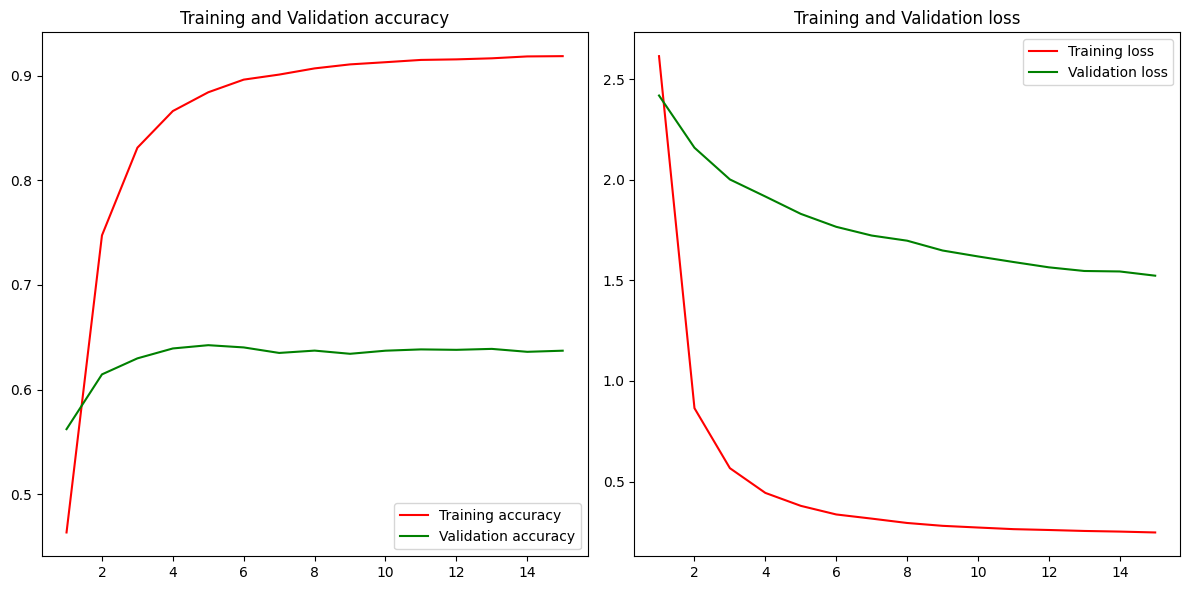

In [73]:
# Display stats
plot_model_accuracy_and_loss(model_flowim_transfer_metrics)

## Transfer Learning while Unfreezing More Layers

In this experiment I will try also unfreezing the last convolutional block before the final Dense layer and see if that changes how fast the model trains or how quickly it can reach a high accuracy score.

In [74]:
# Load the pre-trained model
pretrained_model = tf.keras.models.load_model('/kaggle/input/best-model-flower-image/Model_with_L1L2_Regularization.h5')

# Unfreezing the last 9 layers which practically represent the last residual block and the classification layer
for layer in pretrained_model.layers[:-9]:
    layer.trainable = False

new_output = tf.keras.layers.Dense(num_classes, activation='softmax')(pretrained_model.layers[-2].output)

model_flowim_transfer_2 = tf.keras.Model(inputs=pretrained_model.input, outputs=new_output, name = 'Flower_Image_Transfer_Learning_Model_2')
model_flowim_transfer_2.summary()

Model: "Flower_Image_Transfer_Learning_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout_8 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                            

In [75]:
# Training of the model
model_flowim_transfer_metrics_2 = train_model(model_flowim_transfer_2, train_ds_flowim, val_ds_flowim, 15)

Epoch 1/15


2023-10-17 17:32:44.122469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFlower_Image_Transfer_Learning_Model_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


711/711 [==============================] - 90s 124ms/step - loss: 2.1557 - accuracy: 0.4830 - val_loss: 2.5258 - val_accuracy: 0.5630
Epoch 2/15
711/711 [==============================] - 89s 124ms/step - loss: 0.9325 - accuracy: 0.7323 - val_loss: 2.1363 - val_accuracy: 0.6121
Epoch 3/15
711/711 [==============================] - 99s 138ms/step - loss: 0.6097 - accuracy: 0.8159 - val_loss: 1.8850 - val_accuracy: 0.6145
Epoch 4/15
711/711 [==============================] - 93s 129ms/step - loss: 0.4667 - accuracy: 0.8550 - val_loss: 1.7396 - val_accuracy: 0.6286
Epoch 5/15
711/711 [==============================] - 91s 127ms/step - loss: 0.3849 - accuracy: 0.8778 - val_loss: 1.6715 - val_accuracy: 0.6179
Epoch 6/15
711/711 [==============================] - 88s 123ms/step - loss: 0.3127 - accuracy: 0.9003 - val_loss: 1.5719 - val_accuracy: 0.6377
Epoch 7/15
711/711 [==============================] - 89s 124ms/step - loss: 0.2869 - accuracy: 0.9081 - val_loss: 1.5538 - val_accuracy: 0.6

As the last residual block was notably large compared to the previous layers, the change we applied earlier allowed the model to train almost 2.500.000 of its total 6.400.000 parameters, which is a pretty significant number. As a result, the model managed to use the prior knowledge of the model we imported which was trained on a similar task and achieved close to 85% percentage in this new, different dataset.

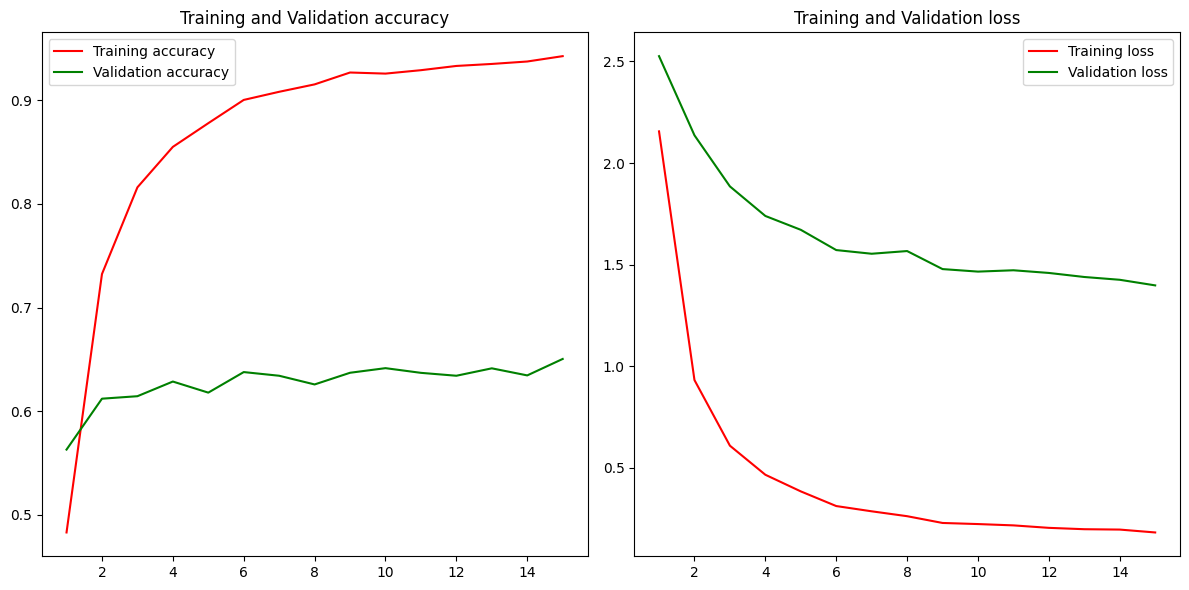

In [76]:
# Display stats
plot_model_accuracy_and_loss(model_flowim_transfer_metrics_2)

#### 4.2.3 Training all the Layers of the Final Model to Compare with the Transfer Learning Results

The question is, though, what would happen if we tried to train a new model from scratch on the indan birds dataset? Would this be more or less efficient regarding both accuracy and training time? Practically what we're doing is using the same model architecture that yielded the best results in the 525 bird species dataset and then training this model in the new dataset without using any pretrained weights.

In [80]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_flowim_new = keras.Model(inputs, outputs, name = 'Flower_Image_Best_Model_anew')

model_flowim_new.summary()

Model: "Flower_Image_Best_Model_anew"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout_43 (Dropout)        (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_56 (Conv2D)          (None, 87, 87, 64)        18496     
                                      

In [81]:
# Training of the model
model_flowim_new_metrics = train_model(model_flowim_new, train_ds_flowim, val_ds_flowim, 15)

Epoch 1/15


2023-10-17 18:09:26.984329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFlower_Image_Best_Model_anew/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


711/711 [==============================] - 109s 150ms/step - loss: 2.9609 - accuracy: 0.2671 - val_loss: 3.4233 - val_accuracy: 0.3925
Epoch 2/15
711/711 [==============================] - 108s 151ms/step - loss: 1.9031 - accuracy: 0.4944 - val_loss: 2.8909 - val_accuracy: 0.5239
Epoch 3/15
711/711 [==============================] - 108s 151ms/step - loss: 1.4068 - accuracy: 0.6136 - val_loss: 2.5414 - val_accuracy: 0.5707
Epoch 4/15
711/711 [==============================] - 110s 153ms/step - loss: 1.1026 - accuracy: 0.6900 - val_loss: 2.3408 - val_accuracy: 0.5932
Epoch 5/15
711/711 [==============================] - 105s 147ms/step - loss: 0.8919 - accuracy: 0.7406 - val_loss: 2.1567 - val_accuracy: 0.6039
Epoch 6/15
711/711 [==============================] - 107s 150ms/step - loss: 0.7398 - accuracy: 0.7810 - val_loss: 1.9702 - val_accuracy: 0.6113
Epoch 7/15
711/711 [==============================] - 109s 152ms/step - loss: 0.6321 - accuracy: 0.8090 - val_loss: 1.8372 - val_accura

After training this model for 15 epochs we can see that the validation accuracy is lower than the one achieved in the transfer learning model. Also the model took more time to train those 15 epochs as it had to adjust a greater number of parameters. From the following plot it is obvious, tough,  that if the training were to resume for more epochs we would probably surpass the pretrained model's accuracy. The main benefit of transfer learning is that we can use the weight of a model that was trained on a similar task to achieve high accuracy on a similar dataset, thus reducing the training time significantly. Of course, training a model from scratch is expected to give better results after a large number of epochs, but this requires a lot of computational power and more time that can be reduced significantly if we use transfer learning.

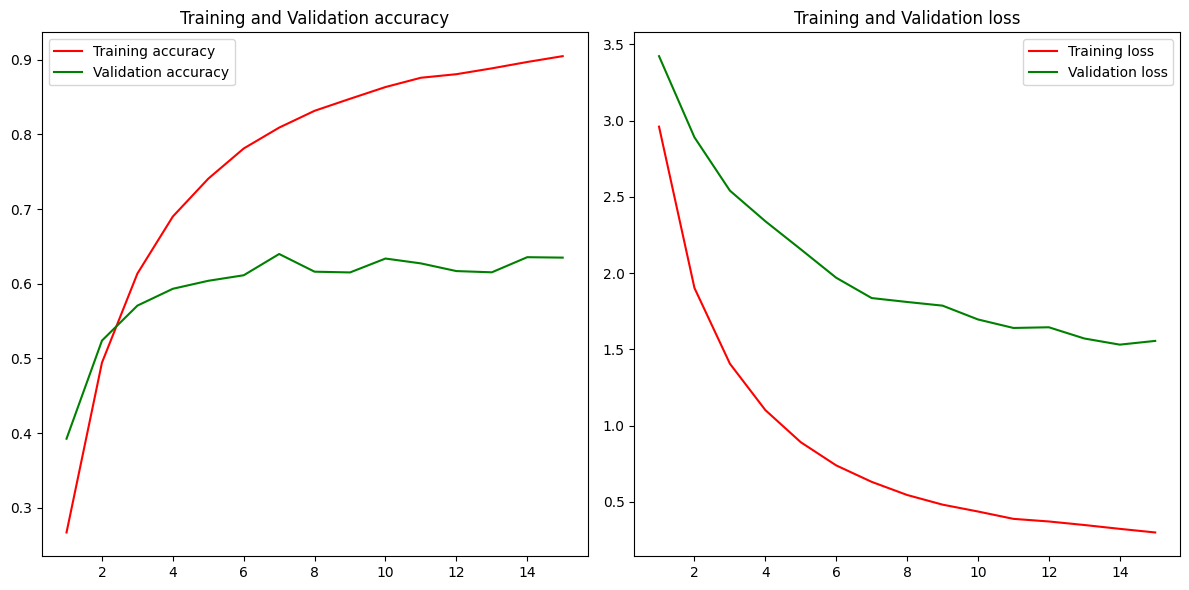

In [82]:
# Display stats
plot_model_accuracy_and_loss(model_flowim_new_metrics)

## 5. Final Observations and Conclusion

As a closing statement, we could say that in most cases it is better to finetune a pretrained model on a similar task than train a new model from scratch on most datasets. Transfer learning allows us to use the prior knowledge of similar models, thus cutting down both training time and computational requirements. Especially for smaller datasets, transfer learning models can achieve good results while this is not the case for most models without prior knowledge.

In [105]:
print(tabulate(global_model_stats, headers=['Model Name', 'Training Time', 'Number of Epochs', 'Training Time per Epoch', 'Training Accuracy', 'Validation Accuracy'], tablefmt="fancy_grid"))

╒════════════════════════════════════════╤═════════════════╤════════════════════╤═══════════════════════════╤═════════════════════╤═══════════════════════╕
│ Model Name                             │   Training Time │   Number of Epochs │   Training Time per Epoch │   Training Accuracy │   Validation Accuracy │
╞════════════════════════════════════════╪═════════════════╪════════════════════╪═══════════════════════════╪═════════════════════╪═══════════════════════╡
│ Flower_Image_Transfer_Learning_Model   │            1566 │                 15 │                    104.4  │            0.918491 │              0.642428 │
├────────────────────────────────────────┼─────────────────┼────────────────────┼───────────────────────────┼─────────────────────┼───────────────────────┤
│ Flower_Image_Transfer_Learning_Model_2 │            1670 │                 15 │                    111.33 │            0.942495 │              0.650407 │
├────────────────────────────────────────┼─────────────────┼────